# PU-Learning Experiment Environment

## Libraries

In [2]:
import torch
from torch.utils import data
import torch.nn as nn
import numpy as np
from scipy.stats import gaussian_kde
import pandas as pd
from scipy.stats import binom
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from ipywidgets import IntProgress
from IPython.display import display

## Data Stuff

### Data Stuff for Homemade Classifier

In [3]:
class Gaussain_data(torch.utils.data.Dataset):

    def __init__(self, pos_mu, pos_sigma, pos_size, neg_mu, neg_sigma, neg_size):
        
        dim = 1
        
        input_pos = np.random.multivariate_normal(pos_mu*np.ones(dim), pos_sigma*np.eye(dim), pos_size)
        
        input_neg = np.random.multivariate_normal(neg_mu*np.ones(dim), neg_sigma*np.eye(dim), neg_size)
        
        self.p_data  = input_pos.astype(np.float32)
        self.n_data  = input_neg.astype(np.float32)
        
    def __len__(self): 
        return len(self.n_data) + len(self.p_data)

In [4]:
class PosData(torch.utils.data.Dataset): 
    
    def __init__(self, data=None, index=None):
        self.data=data
        self.targets = np.zeros(data.shape[0], dtype= np.int_)
        self.index = index

    def __len__(self): 
        return len(self.targets)

    def __getitem__(self, idx):
        index, point, target = self.index[idx],  self.data[idx], self.targets[idx]
    
        return index, point, target

In [5]:
class UnlabelData(torch.utils.data.Dataset):
    
    def __init__(self, pos_data=None, neg_data=None, index=None):
        self.data=np.concatenate((pos_data, neg_data), axis=0)
        self.true_targets = np.concatenate((np.zeros(pos_data.shape[0], dtype= np.int_)\
                                            , np.ones(neg_data.shape[0],  dtype= np.int_)), axis=0)
        self.targets = np.ones_like(self.true_targets, dtype= np.int_)
        self.index = index

    def __len__(self): 
        return len(self.targets)
    
    def __getitem__(self, idx):
        index, img, target = self.index[idx],  self.data[idx], self.targets[idx]
        return index, img, target

In [6]:
def get_dataset(alpha, beta, batch_size=200, \
                pos_mu=8, pos_sigma=1, pos_size=2000, neg_mu=3, neg_sigma=1, neg_size=2000): 

    p_trainloader=None
    u_trainloader=None
    p_validloader=None
    u_validloader=None
    
    unlabel_size = int((1-beta)*pos_size/beta)

    num_points = 2*(pos_size+unlabel_size) # Number of pos/neg points to generate
    
    gauss_traindata = Gaussain_data(pos_mu=pos_mu, pos_sigma=pos_sigma, pos_size=num_points,\
                                   neg_mu=neg_mu, neg_sigma=neg_sigma, neg_size=num_points)
    gauss_testdata = Gaussain_data(pos_mu=pos_mu, pos_sigma=pos_sigma, pos_size=num_points,\
                                   neg_mu=neg_mu, neg_sigma=neg_sigma, neg_size=num_points)

    p_traindata, u_traindata = get_PUDataSplits(gauss_traindata, pos_size=pos_size, alpha=alpha, beta=beta)
    p_validdata , u_validdata = get_PUDataSplits(gauss_testdata, pos_size=pos_size, alpha=alpha, beta=beta)

    pu_traindata = torch.utils.data.ConcatDataset([p_traindata, u_traindata])
    pu_validdata = torch.utils.data.ConcatDataset([p_validdata, u_validdata])

    p_trainloader = torch.utils.data.DataLoader(p_traindata, batch_size=batch_size, \
        shuffle=True, num_workers=2)
    u_trainloader = torch.utils.data.DataLoader(u_traindata, batch_size=batch_size, \
        shuffle=True, num_workers=2)
    p_validloader = torch.utils.data.DataLoader(p_validdata, batch_size=batch_size, \
        shuffle=True, num_workers=2)
    u_validloader = torch.utils.data.DataLoader(u_validdata, batch_size=batch_size, \
        shuffle=True, num_workers=2)
    
    pu_trainloader = torch.utils.data.DataLoader(pu_traindata, batch_size=batch_size, \
        shuffle=True, num_workers=2)
    pu_validloader = torch.utils.data.DataLoader(pu_validdata, batch_size=batch_size, \
        shuffle=True, num_workers=2)

    return p_trainloader, u_trainloader, pu_trainloader, p_validloader, u_validloader, pu_validloader

In [7]:
def get_PUDataSplits(data_obj, pos_size, alpha, beta, data_type=None): 

    unlabel_size = int((1-beta)*pos_size/beta)
    
    '''
    Assert makes sure the generated pool is big enough to draw from
    '''
    assert ((pos_size + int(unlabel_size*alpha)) < len(data_obj.p_data)), "Check sizes again--not enough positive data"
    assert ((int(unlabel_size*(1-alpha))) < len(data_obj.n_data)), "Check sizes again--not enough negative data"

    pos_data = data_obj.p_data[:pos_size]
    neg_data = data_obj.n_data
    unlabel_pos_data = data_obj.p_data[pos_size: pos_size+ int(unlabel_size*alpha)]
    unlabel_neg_data = data_obj.n_data[:int(unlabel_size*(1-alpha))]

    
    return PosData(data=pos_data, index=np.array(range(pos_size))), \
            UnlabelData(pos_data=unlabel_pos_data, neg_data=unlabel_neg_data, \
                index=np.array(range(unlabel_size)))


### Data Stuff for SK Classifier

In [8]:
def get_sk_data(alpha= 0.5, pos_mu=8, pos_sigma=1, pos_size=2000,\
                neg_mu=3, neg_sigma=1, unl_size=2000):
    
    rng = np.random.default_rng()
    
    pos_data = rng.normal(loc=pos_mu, size=pos_size)
    pos_unl_data = rng.normal(loc=pos_mu, size=int(alpha*unl_size))
    neg_unl_data = rng.normal(loc=neg_mu, size=int((1-alpha)*unl_size))
    unl_data = np.concatenate((pos_unl_data,neg_unl_data))
    
    pos_labels = np.zeros_like(pos_data)
    unl_labels = np.ones_like(unl_data)
    
    X=np.concatenate((pos_data,unl_data)).reshape((-1, 1))
    y=np.concatenate((pos_labels,unl_labels))
    
    p = np.random.permutation(len(X))
    X,y = X[p], y[p]
    
    p2 = np.random.permutation(len(unl_data))
    unl_data = unl_data[p2]
    
    return X,y, pos_data, unl_data

## NTC Classifier and Probability Stuff

### Homemade Classifier

In [9]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

In [10]:
def train_model(model, train_dl, test_dl = None, eval=True, n_iters = 10000):
    
    iter = 0
    
    num_epochs = int(n_iters/(len(train_dl.dataset)/train_dl.batch_size)) # number of epochs = n_iters / (len(train_dataset) / batch_size)
    
    if eval==True:
        print(f'    total training data size: {len(train_dl.dataset)}')
        print(f'    batch size: {train_dl.batch_size}')
        print(f'    n_iters: {n_iters}')
        print(f'    num_epochs: {num_epochs}')
        print()
        print("Training Info:")
    
    learning_rate = 0.001
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):

        for i, (_, data, labels) in enumerate(train_dl):

            data = data.view(-1, 1).requires_grad_()
            labels = labels

            optimizer.zero_grad()

            outputs = model(data) 

            loss = criterion(outputs,labels)

            loss.backward()

            optimizer.step()
            
            iter += 1
            
            if (iter%(n_iters//10) == 0) and not(test_dl is None) and (eval == True):
                
                correct = 0
                total = 0
                for i, (_, data, labels) in enumerate(test_dl):
                    data = data.view(-1,1).requires_grad_()
                    outputs = model(data)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum()
                accuracy = 100*correct/total
                
                print(f"    Iteration: {iter}, Loss: {loss.item()}, Accuracy: {accuracy}%")            

In [11]:
def get_probs(model, p_data, u_data):
    
    p_probs = None
    u_probs = None
    u_labels = None
    
    softMax = nn.Softmax(dim=1)
    
    for i, (_, data, labels) in enumerate(p_data):
        
        outputs = model(data)
        
        probs = softMax(outputs)
        
        if p_probs is None:
                p_probs = probs.detach().numpy()
        else:
            p_probs = np.concatenate((p_probs, probs.detach().numpy()), axis=0)
            
    p_probs = np.delete(p_probs, 1, 1) # Remove the unlabeled probability
    p_probs = p_probs.squeeze() # squeeze into array of floats (probabilities)
            
    for i, (_, data, labels) in enumerate(u_data):
        
        outputs = model(data)
        
        probs = softMax(outputs)
        
        if u_probs is None:
                u_probs = probs.detach().numpy()
        else:
            u_probs = np.concatenate((u_probs, probs.detach().numpy()), axis=0)
        
        if u_labels is None:
            u_labels = labels.numpy()
        else:
            u_labels = np.concatenate((u_labels, labels.numpy()), axis = 0)
            
    
    u_probs = np.delete(u_probs, 1, 1) # Remove the unlabeled probability
    u_probs = u_probs.squeeze() # squeeze into array of floats (probabilities)
    
    u_labels = u_labels.squeeze() # squeeze into array of ints (class labels where 1 = unlabeled)
    
    #print(f"p_probs: {p_probs}")
    #print(f"u_probs: {u_probs}")
    #print(f"u_labels: {u_labels}")
    
    return p_probs, u_probs, u_labels

### SK Classifier

In [12]:
def sk_get_probs(clf, pos_data,unl_data):
    pos_probs = []
    unl_probs = []
    
    for point in pos_data:
        prob = clf.predict_proba([[point]])[0][0]
        pos_probs.append(prob)
        
    for point in unl_data:
        prob = clf.predict_proba([[point]])[0][0]
        unl_probs.append(prob)
        
    return np.array(pos_probs), np.array(unl_probs), np.ones_like(unl_probs)

In [13]:
def sk_train(X,y):
    clf = LogisticRegression(random_state=0).fit(X, y)
    
    return clf

## MPE Algorithms

### Best Bin Estimation (BBE)
From: [*Mixture Proportion Estimation and PU Learning: A Modern Approach*](https://proceedings.neurips.cc/paper/2021/file/47b4f1bfdf6d298682e610ad74b37dca-Paper.pdf)

In [14]:
def BBE_estimator(pdata_probs, udata_probs, udata_targets):

    p_indices = np.argsort(pdata_probs) # indicies, smallest vlaue to largest value
    sorted_p_probs = pdata_probs[p_indices] # array of p_probs, smallest to biggest
    sorted_p_probs = sorted_p_probs[::-1] # array of p_probs, biggest to smallest
    
    
    u_indices = np.argsort(udata_probs) # indicies, smallest vlaue to largest value
    sorted_u_probs = udata_probs[u_indices] # array of u_probs, smallest to biggest
    sorted_u_probs = sorted_u_probs[::-1] # array of u_probs, biggest to smallest
    
    
    sorted_u_targets = udata_targets[u_indices] 
    sorted_u_targets = sorted_u_targets[::-1]
    
    
    num = len(sorted_u_probs)
    
    estimate_arr = []

    upper_cfb = []
    lower_cfb = []            

    i = 0
    j = 0
    num_u_samples = 0

    while (i < num):
        start_interval =  sorted_u_probs[i]   
        k = i 
        if (i<num-1 and start_interval> sorted_u_probs[i+1]): 
            pass
        else: 
            i += 1
            continue
        if (sorted_u_targets[i]==1):
            num_u_samples += 1

        while ( j<len(sorted_p_probs) and sorted_p_probs[j] >= start_interval):
        #while (np.logical_and( j<len(sorted_p_probs), sorted_p_probs[j] >= start_interval)):
            j+= 1

        if j>1 and i > 1:
            t = (i)*1.0*len(sorted_p_probs)/j/len(sorted_u_probs)
            estimate, lower , upper = DKW_bound(i, j, t, len(sorted_u_probs), len(sorted_p_probs))
            estimate_arr.append(estimate)
            upper_cfb.append( upper)
            lower_cfb.append( lower)
        i+=1

    if (len(upper_cfb) != 0): 
        idx = np.argmin(upper_cfb)
        mpe_estimate = estimate_arr[idx]

        return mpe_estimate, lower_cfb, upper_cfb
    else: 
        return 0.0, 0.0, 0.0
    
def DKW_bound(x,y,t,m,n,delta=0.1, gamma= 0.01):

    temp = np.sqrt(np.log(1/delta)/2/n) + np.sqrt(np.log(1/delta)/2/m)
    bound = temp*(1+gamma)/(y/n)

    estimate = t

    return estimate, t - bound, t + bound


### DEDPUL
From: [*DEDPUL: Difference-of-Estimated-Densities-based
Positive-Unlabeled Learning*](https://ieeexplore-ieee-org.ezproxy.library.uvic.ca/stamp/stamp.jsp?tp=&arnumber=9356188)

In [15]:
def dedpul(pdata_probs, udata_probs,udata_targets):

    udata_probs = 1-udata_probs
    alpha = None
    poster = np.zeros_like(udata_probs)
    preds = np.concatenate(((1.0 - pdata_probs), udata_probs),axis=0)
    targets = np.concatenate((np.zeros_like(pdata_probs), np.ones_like(udata_probs)), axis=0 )
    
    diff = estimate_diff(preds, targets) 
    alpha, poster = estimate_poster_em(diff=diff, mode='dedpul', alpha=None)

    if alpha<=1e-4: 
        alpha, poster =  estimate_poster_dedpul(diff=diff, alpha=alpha)
    


    return 1 - alpha, poster


In [16]:
def estimate_diff(preds, target, bw_mix=0.05, bw_pos=0.1, kde_mode='logit', threshold='mid', k_neighbours=None,
                  tune=False, MT=False, MT_coef=0.25, decay_MT_coef=False, kde_type='kde', bins_mix=20, bins_pos=20):
    """
    Estimates densities of predictions y(x) for P and U and ratio between them f_p / f_u for U sample;
        uses kernel density estimation (kde);
        post-processes difference of estimated densities - imposes monotonicity on lower preds
        (so that diff is partly non-decreasing) and applies rolling median to further reduce variance
    :param preds: predictions of NTC y(x), probability of belonging to U rather than P, np.array with shape (n,)
    :param target: binary vector, 0 if positive, 1 if unlabeled, np.array with shape (n,)
    :param bw_mix: bandwidth for kde of U
    :param bw_pos: bandwidth for kde of P
    :param kde_mode: 'prob', 'log_prob' or 'logit'; default is 'logit'
    :param monotonicity: monotonicity is imposed on density difference for predictions below this number, float in [0, 1]
    :param k_neighbours: difference is relaxed with median rolling window with size k_neighbours * 2 + 1,
        default = int(preds[target == 1].shape[0] // 10)
    :return: difference of densities f_p / f_u for U sample
    """

    if kde_mode is None:
        kde_mode = 'logit'

    if (threshold is None) or (threshold == 'mid'):
        threshold = preds[target == 1].mean() / 2 + preds[target == 0].mean() / 2

    if k_neighbours is None:
        k_neighbours = int(preds[target == 1].shape[0] // 20)

    kde_inner_fun = lambda x: np.log((x + 1e-7) / (1 - x + 10 ** -5))
    kde_outer_fun = lambda dens, x: dens(np.log((x + 1e-7) / (1 - x + 10 ** -5))) / (x * (1 - x) + 10 ** -5)

    kde_mix = gaussian_kde(np.apply_along_axis(kde_inner_fun, 0, preds[target == 1]), bw_mix)
    kde_pos = gaussian_kde(np.apply_along_axis(kde_inner_fun, 0, preds[target == 0]), bw_pos)

        
    #PLOT KDE's    
    #ax = pd.Series(np.apply_along_axis(kde_inner_fun, 0, preds[target == 1])).plot.kde(bw_method = bw_mix)
    #ax = pd.Series(np.apply_along_axis(kde_inner_fun, 0, preds[target == 0])).plot.kde(bw_method = bw_pos)



    # sorting to relax and impose monotonicity
    sorted_mixed = np.sort(preds[target == 1])

    diff = np.apply_along_axis(lambda x: kde_outer_fun(kde_pos, x) / (kde_outer_fun(kde_mix, x) + 10 ** -5), axis=0,
                               arr=sorted_mixed)
    diff[diff > 50] = 50
    diff = rolling_apply(diff, 5)
    diff = np.append(
        np.flip(np.maximum.accumulate(np.flip(diff[sorted_mixed <= threshold], axis=0)), axis=0),
        diff[sorted_mixed > threshold])
    diff = rolling_apply(diff, k_neighbours)


    diff.sort()
    diff = np.flip(diff, axis=0)

    # desorting
    diff = diff[np.argsort(np.argsort(preds[target == 1]))]

    return diff

In [17]:
def estimate_poster_em(diff=None, mode='dedpul', converge=True, tol=10**-5, max_iterations=1000, \
                       nonconverge=True, step=0.001, max_diff=0.05, disp=False,
                       alpha=None, alpha_as_mean_poster=True, **kwargs):
    """
    Performs Expectation-Maximization to estimate posteriors and priors alpha (if not provided) of N in U
        with either of 'en' or 'dedpul' methods; both 'converge' and 'nonconverge' are recommended to be set True for
        better estimate
    :param diff: difference of densities f_p/f_u for the sample U, np.array (n,), output of estimate_diff()
    :param preds: predictions of classifier, np.array with shape (n,)
    :param target: binary vector, 0 if positive, 1 if unlabeled, np.array with shape (n,)
    :param mode: 'dedpul' or 'en'; if 'dedpul', diff needs to be provided; if 'en', preds and target need to be provided
    :param converge: True or False; True if convergence estimate should be computed
    :param tol: tolerance of error between priors and mean posteriors, indicator of convergence
    :param max_iterations: if exceeded, search of converged alpha stops even if tol is not reached
    :param nonconverge: True or False; True if non-convergence estimate should be computed
    :param step: gap between points of the [0, 1, step] gird to choose best alpha from
    :param max_diff: alpha with difference of mean posteriors and priors bigger than max_diff cannot be chosen;
        an heuristic to choose bigger alpha
    :param plot: True or False, if True - plots ([0, 1, grid], mean posteriors - alpha) and
        ([0, 1, grid], second lag of (mean posteriors - alpha))
    :param disp: True or False, if True - displays if the algorithm didn't converge
    :param alpha: proportions of N in U; is estimated if None
    :return: tuple (alpha, poster), e.g. (priors, posteriors) of N in U for the U sample
    """
    assert converge + nonconverge, "At least one of 'converge' and 'nonconverge' has to be set to 'True'"

    if alpha is not None:
        if mode == 'dedpul':
            alpha, poster = estimate_poster_dedpul(diff, alpha=alpha, alpha_as_mean_poster=alpha_as_mean_poster, tol=tol, **kwargs)
        return alpha, poster

    # if converge:
    alpha_converge = 0
    for i in range(max_iterations):

        if mode.endswith('dedpul'):
            _, poster_converge = estimate_poster_dedpul(diff, alpha=alpha_converge, **kwargs)

        mean_poster = np.mean(poster_converge)
        error = mean_poster - alpha_converge

        if np.abs(error) < tol:
            break
        if np.min(poster_converge) > 0:
            break
        alpha_converge = mean_poster

    if disp:
        if i >= max_iterations - 1:
            print('max iterations exceeded')

    # if nonconverge:

    errors = np.array([])
    for alpha_nonconverge in np.arange(0, 1, step):

        if mode.endswith('dedpul'):
            _, poster_nonconverge = estimate_poster_dedpul(diff, alpha=alpha_nonconverge, **kwargs)
        errors = np.append(errors, np.mean(poster_nonconverge) - alpha_nonconverge)

    idx = np.argmax(np.diff(np.diff(errors))[errors[1: -1] < max_diff])
    alpha_nonconverge = np.arange(0, 1, step)[1: -1][errors[1: -1] < max_diff][idx]


    # if converge and not nonconverge:
    #     return alpha_converge, poster_converge

    if ((alpha_nonconverge >= alpha_converge) or#converge and nonconverge and
        (((errors < 0).sum() > 1) and (alpha_converge < 1 - step))):
        return alpha_converge, poster_converge

    elif nonconverge:
        if mode == 'dedpul':
            _, poster_nonconverge = estimate_poster_dedpul(diff, alpha=alpha_nonconverge, **kwargs)

        if disp:
            print('didn\'t converge')
        return alpha_nonconverge, poster_nonconverge
        # return np.mean(poster_nonconverge), poster_nonconverge

    else:
        if disp:
            print('didn\'t converge')
        return None, None


In [18]:
def estimate_poster_dedpul(diff, alpha=None, quantile=0.05, alpha_as_mean_poster=False, max_it=100, **kwargs):
    """
    Estimates posteriors and priors alpha (if not provided) of N in U with dedpul method
    :param diff: difference of densities f_p / f_u for the sample U, np.array (n,), output of estimate_diff()
    :param alpha: priors, share of N in U (estimated if None)
    :param quantile: if alpha is None, relaxation of the estimate of alpha;
        here alpha is estimaeted as infinum, and low quantile is its relaxed version;
        share of posteriors probabilities that we allow to be negative (with the following zeroing-out)
    :param kwargs: dummy
    :return: tuple (alpha, poster), e.g. (priors, posteriors) of N in U for the U sample, represented by diff
    """
    if alpha_as_mean_poster and (alpha is not None):
        poster = 1 - diff * (1 - alpha)
        poster[poster < 0] = 0
        cur_alpha = np.mean(poster)
        if cur_alpha < alpha:
            left_border = alpha
            right_border = 1
        else:
            left_border = 0
            right_border = alpha

            poster_zero = 1 - diff
            poster_zero[poster_zero < 0] = 0
            if np.mean(poster_zero) > alpha:
                left_border = -50
                right_border = 0
                # return 0, poster_zero
        it = 0
        try_alpha = cur_alpha
        while (abs(cur_alpha - alpha) > kwargs.get('tol', 10**-5)) and (it < max_it):
            try_alpha = (left_border + (right_border - left_border) / 2)
            poster = 1 - diff * (1 - try_alpha)
            poster[poster < 0] = 0
            cur_alpha = np.mean(poster)
            if cur_alpha > alpha:
                right_border = try_alpha
            else:
                left_border = try_alpha
            it += 1
        alpha = try_alpha
        if it >= max_it:
            print('Exceeded maximal number of iterations in finding mean_poster=alpha')
    else:
        if alpha is None:
            alpha = 1 - 1 / max(np.quantile(diff, 1 - quantile, interpolation='higher'), 1)
        poster = 1 - diff * (1 - alpha)
        poster[poster < 0] = 0

    return 1 - alpha, poster


In [19]:
def rolling_apply(diff, k_neighbours):
    s = pd.Series(diff)
    s = np.concatenate((
                        s.iloc[:2*k_neighbours].expanding().median()[::2].values,
                        s.rolling(k_neighbours*2+1, center=True).median().dropna().values,
                        np.flip(np.flip(s.iloc[-2*k_neighbours:], axis=0).expanding().median()[::2], axis=0).values
    ))
    return s


### Elkan and Noto

In [20]:
def estimator_CM_EN(pdata_probs, pudata_probs):
    return np.sum(pudata_probs)*len(pdata_probs)/len(pudata_probs)/np.sum(pdata_probs)

### Scott

In [21]:
def scott_estimator(pdata_probs, udata_probs):
    p_indices = np.argsort(pdata_probs)
    sorted_p_probs = pdata_probs[p_indices]
    u_indices = np.argsort(udata_probs)
    sorted_u_probs = udata_probs[u_indices]

    sorted_u_probs = sorted_u_probs[::-1]
    sorted_p_probs = sorted_p_probs[::-1]
    num = len(sorted_u_probs)

    j = 0
    num_u_samples = 0
    ratios = []
    delta=0.1
    n = len(sorted_u_probs)
    m = len(sorted_p_probs)
    i = 0
    while (i < num):
        start_interval =  sorted_u_probs[i]   
        k = i 
        if (i<num-1 and start_interval> sorted_u_probs[i+1]): 
            pass
        else: 
            i += 1
            continue

        while ( j<len(sorted_p_probs) and sorted_p_probs[j] >= start_interval):
            j+= 1

        if j>1 and i > 1:
            t = bininv(n, i, delta) / (1.0 - bininv(m, m-j, delta))
            # t = ((i*1.0/n) + np.sqrt(np.log(1/delta)/2/n))/( (j*1.0/m) - + np.sqrt(np.log(1/delta)/2/m))
            # if t > 0: 
            ratios.append(t)
        i+=1

    if len(ratios)!= 0: 
        return np.min(ratios)
    else: 
        return 0.0

In [22]:
def bininv(m,e,c): 
    plo = 0
    phi = 1
    p = .5

    max_iter = 20 
    tol = c*0.001   

    iter = 0;

    while iter <= max_iter:
        iter = iter + 1;
        bintail = binom.cdf(e,m,p)
        if abs(bintail - c) <= tol: 
            return p

        if bintail < c: 
            phi = p
        else: 
            plo = p
        p = (phi + plo)/2

    return p

### My Method

In [23]:
def find_optimal_thresh(pos_probs, unl_probs, gran=101):
    
    pos_probs = np.array(pos_probs)
    unl_probs = np.array(unl_probs)

    thresholds = np.linspace(0,1,gran)

    lop = []
    lou = []
    difs = []
    squared_difs = []
    
    for t in thresholds:
        pos_above = len(pos_probs[pos_probs > t])/len(pos_probs)
        unl_above = len(unl_probs[unl_probs > t])/len(unl_probs)

        lop.append(pos_above)
        lou.append(unl_above)
        difs.append(abs(pos_above-unl_above))
        squared_difs.append(((pos_above-unl_above)**2))
    
    max_dif_idx = np.argmax(difs)
    opt_thresh = thresholds[max_dif_idx]
    
    return opt_thresh, thresholds, lop, lou, difs, squared_difs

In [24]:
def my_method(clf, pos_data, unl_data):
    
    pos_probs = []
    unl_probs = []
    
    p_count = 1 # Initialize to 1 to avoid div by 0
    n_count = 1
    
    for point in pos_data:
        prob = clf.predict_proba([[point]])[0][0]
        pos_probs.append(prob)
    
    for point in unl_data:
        prob = clf.predict_proba([[point]])[0][0]
        unl_probs.append(prob)
    
    opt_thresh, thresholds, lop, lou,\
        difs, squared_difs = find_optimal_thresh(pos_probs, unl_probs, gran=101)
    
    for point in unl_data:
        prob = clf.predict_proba([[point]])[0][0]
        
        if prob > opt_thresh:
            p_count += 1
        else:
            n_count += 1
            
    return p_count/(p_count+n_count)
            
    
    

## Experiment Script (Homemade Classifier)

In [25]:
def run_experiment(alpha=0.5, beta=0.5,\
                   pos_mu=8, pos_sigma=1, neg_mu=3, neg_sigma=1, \
                   pos_size=2000, n_iters=10000, eval=False):
    
    
    if eval==True:
        print("Data info:")
        print(f'    alpha: {alpha}')
        print(f'    beta: {beta}')
        print(f'    pos_size: {pos_size}')
        print(f'    unlabeled_size: {int((1-beta)*pos_size/beta)}')
    
    # Get the data set
    p_trainloader, u_trainloader, pu_trainloader, p_validloader, u_validloader, pu_validloader = \
        get_dataset(alpha=alpha, beta=beta,\
                    pos_mu=pos_mu,pos_sigma=pos_sigma,\
                    neg_mu=neg_mu, neg_sigma=neg_sigma,\
                    pos_size = pos_size)
    
    # Initialize the model
    input_dim = 1 # 1D Gaussian
    output_dim = 2 # 2 classes (PvU)
    model = LogisticRegressionModel(input_dim, output_dim)
    
    # Train the Model
    train_model(model, pu_trainloader, pu_validloader, eval=eval, n_iters = n_iters)
    
    # Get the probabilities
    p_probs, u_probs, u_labels = get_probs(model, p_validloader, u_validloader)
    
    # Do MPE methods
    BBE_estimate, _, _ = BBE_estimator(p_probs, u_probs, u_labels)
    dedpul_estimate, dedpul_probs = dedpul(p_probs, u_probs, u_labels)
    EN_estimate= estimator_CM_EN(p_probs, u_probs)
    scott_mpe_estimator = scott_estimator(p_probs, u_probs)
    
    if eval == True:
        print()
        print("MPE info:")
        print(f'    True MP: {alpha}')
        print(f'    ------------------------')
        print(f'    BBE: {BBE_estimate}')
        print(f'    DEDPUL: {dedpul_estimate}')
        print(f'    EN: {EN_estimate}')
        print(f'    Scott: {scott_mpe_estimator}')
    return alpha, BBE_estimate, dedpul_estimate, EN_estimate, scott_mpe_estimator

## Experiment Script (SK Classifier)

In [26]:
def run_experiment_sk(alpha=0.5,\
                   pos_mu=8, pos_sigma=1, neg_mu=3, neg_sigma=1, \
                   pos_size=2000, unl_size = 2000, eval=False):
    
    X,y,_,_ = get_sk_data(alpha=alpha,pos_mu=pos_mu,pos_sigma=pos_sigma,pos_size=pos_size,\
                neg_mu=neg_mu, neg_sigma=1, unl_size=unl_size)
    
    clf = sk_train(X,y)
    
    _,_,pos_test, unl_test = get_sk_data(alpha=alpha, pos_mu=pos_mu, pos_sigma=pos_sigma, pos_size=pos_size,\
                neg_mu=neg_mu, neg_sigma=neg_sigma, unl_size=unl_size)
    
    p_probs, u_probs, u_labels = sk_get_probs(clf, pos_test,unl_test)
    
    BBE_estimate, _, _ = BBE_estimator(p_probs, u_probs, u_labels)
    dedpul_estimate, dedpul_probs = dedpul(p_probs, u_probs, u_labels)
    EN_estimate= estimator_CM_EN(p_probs, u_probs)
    scott_mpe_estimator = scott_estimator(p_probs, u_probs)
    my_est = my_method(clf, pos_test, unl_test)
    
    if eval==True:
        print("MPE info:")
        print(f'    True MP: {alpha}')
        print(f'    ------------------------')
        print(f'    BBE: {BBE_estimate}')
        print(f'    DEDPUL: {dedpul_estimate}')
        print(f'    EN: {EN_estimate}')
        print(f'    Scott: {scott_mpe_estimator}')
        print(f'    My Method: {my_est}')
        
        
    return alpha, BBE_estimate, dedpul_estimate, EN_estimate, scott_mpe_estimator, my_est

## Experiments with My Method using SK Classifier

### run_experiment_sk
#### Bugs:
- Haven't found any yet...

#### ToDo:
- (Minor) Based on the way data is generated, sigma is fixed to 1. Need to update this. 

#### Parameters:
- alpha $\in [0,1]$ | default: 0.5
    - The mixture proportion of the unlabeled samples
    - Ex. If alpha = 0.4, 40% of the unlabeled samples will be positive and the rest will be negative
- pos_mu $\in \mathbb{R}$ | default: 8
    - The mean of the positive data
- pos_sigma $\in \mathbb{R}$ | default: 1
    - The variance of the positive data
- neg_mu $\in \mathbb{R}$ | default: 3
    - The mean of the negative data
- neg_sigma $\in \mathbb{R}$ | default: 1
    - The variance of the negative data
- pos_size $\in \mathbb{Z}$ | default: 2000
    - The number of positive samples
- unl_size $\in \mathbb{Z}$ | default: 2000
    - The number of unlabeled samples
    - Note: Split between positive and negative according to value of alpha
- eval | default: False
    - If true, will print information. Otherwise, no printing.

#### Returns:
- alpha, BBE_estimate, dedpul_estimate, EN_estimate, scott_mpe_estimator, my_est
    - Note: alpha is the true alpha of the generated data

### Single Trial

In [50]:
run_experiment_sk(alpha = 0.8,eval=True)

MPE info:
    True MP: 0.8
    ------------------------
    BBE: 0.7915987670570844
    DEDPUL: 0.789781641088545
    EN: 0.8685411422584278
    Scott: 0.8110623110582369
    My Method: 0.7961019490254873


(0.8,
 0.7915987670570844,
 0.789781641088545,
 0.8685411422584278,
 0.8110623110582369,
 0.7961019490254873)

### Average Absolute Error (n=10) While Varying Beta

In [45]:
n = 10

alpha_values = np.linspace(0.1,0.9,9)

true_alpha = []
true_alpha_errors = np.zeros_like(alpha_values)
BBE_estimates = []
BBE_error_alpha = []
dedpul_estimates = []
dedpul_error_alpha = []
EN_estimates = []
EN_error_alpha = []
scott_estimates = []
scott_error_alpha = []
my_estimates = []
my_error_alpha = []

f = IntProgress(min=0, max=n*(len(alpha_values))) #Instantiate progress bar
display(f)

for value in alpha_values:
    
        
    BBE_sum = 0
    dedpul_sum = 0
    EN_sum = 0
    scott_sum = 0
    my_sum = 0
    
    for _ in range(n):
        
        alpha, BBE_estimate, dedpul_estimate, EN_estimate, scott_mpe_estimator, my_est = run_experiment_sk(alpha=value, eval=False)
        
        BBE_sum += abs(BBE_estimate - alpha)
        dedpul_sum += abs(dedpul_estimate - alpha)
        EN_sum += abs(EN_estimate - alpha)
        scott_sum += abs(scott_mpe_estimator - alpha)
        my_sum += abs(my_est - alpha)
        
        f.value += 1
        
        
    
    BBE_error_alpha.append(BBE_sum/n)
    dedpul_error_alpha.append(dedpul_sum/n)
    EN_error_alpha.append(EN_sum/n)
    scott_error_alpha.append(scott_sum/n)
    my_error_alpha.append(my_sum/n)

IntProgress(value=0, max=90)

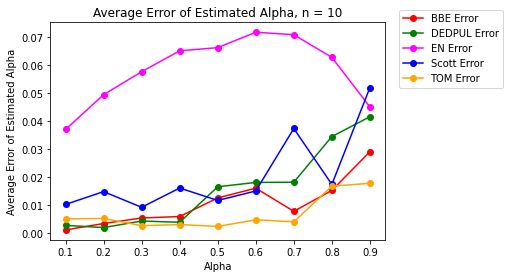

In [51]:
plt.plot(alpha_values, BBE_error_alpha, color='red', marker='o', label="BBE Error")
plt.plot(alpha_values, dedpul_error_alpha, color='green', marker='o', label="DEDPUL Error")
plt.plot(alpha_values, EN_error_alpha, color='magenta', marker='o', label="EN Error")
plt.plot(alpha_values, scott_error_alpha, color='blue', marker='o', label="Scott Error")
plt.plot(alpha_values, my_error_alpha, color='orange', marker='o', label="TOM Error")

plt.legend(loc=(1.04,0.7))
plt.xlabel("Alpha")
plt.ylabel(f"Average Error of Estimated Alpha")
plt.title(f'Average Error of Estimated Alpha, n = {n}')

print()

### Average Absolute Error (n=10) While Varying Beta

In [47]:
n = 10

total_size = 4000
beta_values = np.linspace(0.1,0.9,9)
pos_sizes = [int(x*total_size) for x in beta_values]
unl_sizes = [int(total_size-x) for x in pos_sizes]
sizes = list(zip(pos_sizes, unl_sizes))

true_alpha = []
true_alpha_errors = np.zeros_like(alpha_values)
BBE_estimates = []
BBE_error_beta = []
dedpul_estimates = []
dedpul_error_beta = []
EN_estimates = []
EN_error_beta = []
scott_estimates = []
scott_error_beta = []
my_estimates = []
my_error_beta = []

f = IntProgress(min=0, max=n*(len(sizes))) #Instantiate progress bar
display(f)

for size in sizes:
    
    BBE_sum = 0
    dedpul_sum = 0
    EN_sum = 0
    scott_sum = 0
    my_sum = 0
    
    for _ in range(n):
        
        alpha, BBE_estimate, dedpul_estimate, EN_estimate, scott_mpe_estimator, my_est = run_experiment_sk(pos_size=size[0],unl_size=size[1], eval=False)
        
        BBE_sum += abs(BBE_estimate - alpha)
        dedpul_sum += abs(dedpul_estimate - alpha)
        EN_sum += abs(EN_estimate - alpha)
        scott_sum += abs(scott_mpe_estimator - alpha)
        my_sum += abs(my_est - alpha)
        
        f.value += 1
        
        
    
    BBE_error_beta.append(BBE_sum/n)
    dedpul_error_beta.append(dedpul_sum/n)
    EN_error_beta.append(EN_sum/n)
    scott_error_beta.append(scott_sum/n)
    my_error_beta.append(my_sum/n)

IntProgress(value=0, max=90)

Text(0.5, 1.0, 'Error of Estimated Alpha with Varying Beta, n = 10')

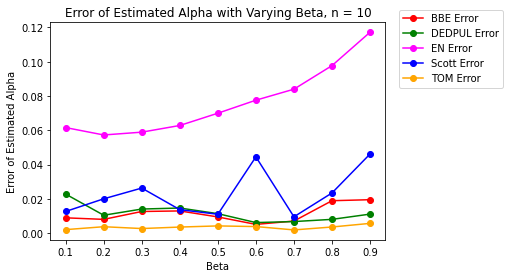

In [52]:
plt.plot(beta_values, BBE_error_beta, color='red', marker='o', label="BBE Error")
plt.plot(beta_values, dedpul_error_beta, color='green', marker='o', label="DEDPUL Error")
plt.plot(beta_values, EN_error_beta, color='magenta', marker='o', label="EN Error")
plt.plot(beta_values, scott_error_beta, color='blue', marker='o', label="Scott Error")
plt.plot(beta_values, my_error_beta, color='orange', marker='o', label="TOM Error")

plt.legend(loc=(1.04,0.7))
plt.xlabel("Beta")
plt.ylabel("Error of Estimated Alpha")
plt.title(f'Error of Estimated Alpha with Varying Beta, n = {n}')

## Experiments with Homemade Classifier (Slow)

### run_experiment
#### Bugs:
- Seems to be an issue with the EN method

#### Parameters:
- alpha $\in [0,1]$ | default: 0.5
    - The mixture proportion of the unlabeled samples
    - Ex. If alpha = 0.4, 40% of the unlabeled samples will be positive and the rest will be negative
- beta $\in [0,1]$ | default: 0.5
    - The proportion of positive samples
    - Ex. If beta = 0.3, 30% of the samples will be positive and the other 70% will be negative
- pos_mu $\in \mathbb{R}$ | default: 8
    - The mean of the positive data
- pos_sigma $\in \mathbb{R}$ | default: 1
    - The variance of the positive data
- neg_mu $\in \mathbb{R}$ | default: 3
    - The mean of the negative data
- neg_sigma $\in \mathbb{R}$ | default: 1
    - The variance of the negative data
- pos_size $\in \mathbb{Z}$ | default: 2000
    - The number of positive samples
    - Note: In conjuntion with beta, this also determines the size of the unlabeled dataset
- n_iters $\in \mathbb{Z}$ | default: 10000
    - How many times we update the classifier
    - Ex. If pos_size = 2000, beta = 0.5, then we will have 4000 data points overall. The default batch size is 200, so one epoch will contain 4000/200 = 20 iterations. So, we will then have (10000 total iterations)/(20 iterations per epoch) = 500 epochs.
- eval | default: False
    - If true, will print information. Otherwise, no printing.

#### Returns:
- (alpha, BBE_estimate, dedpul_estimate, EN_estimate, scott_mpe_estimator)

### Single Trial

In [ ]:
run_experiment(alpha=0.2, beta = 0.5,pos_size=2000,n_iters=2000,eval=True)

### Varying alpha (w/ Homemade Classifier)

In [ ]:
alpha_values = np.linspace(0.1,0.9,9)

true_alpha = []
true_alpha_errors = np.zeros_like(alpha_values)
BBE_estimates = []
BBE_error = []
dedpul_estimates = []
dedpul_error = []
EN_estimates = []
EN_error = []
scott_estimates = []
scott_error = []

for value in alpha_values:
    
    alpha, BBE_estimate, dedpul_estimate, EN_estimate, scott_mpe_estimator = run_experiment(alpha=value, beta = 0.5,pos_size=2000,n_iters=10000,eval=False)
    
    true_alpha.append(alpha)
    BBE_estimates.append(BBE_estimate)
    dedpul_estimates.append(dedpul_estimate)
    EN_estimates.append(EN_estimate)
    scott_estimates.append(scott_mpe_estimator)
    
    BBE_error.append(BBE_estimate - alpha)
    dedpul_error.append(dedpul_estimate - alpha)
    EN_error.append(EN_estimate - alpha)
    scott_error.append(scott_mpe_estimator - alpha)

In [ ]:
plt.plot(alpha_values, true_alpha, 'k--', alpha_values, BBE_estimates, '-ro',\
        alpha_values, dedpul_estimates, '-go', alpha_values, EN_estimates, '-yo',\
        alpha_values, scott_estimates, '-bo')
plt.legend(['True Alpha', 'BBE', 'DEDPUL', 'EN', 'Scott'])
plt.xlabel("True Alpha")
plt.ylabel("Estimated Alpha")
plt.title('Estimated Alpha vs. True Alpha')


#### Average (Absolute) Error Over 3 Trials

In [ ]:
alpha_values = np.linspace(0.1,0.9,9)

true_alpha = []
true_alpha_errors = np.zeros_like(alpha_values)
BBE_estimates = []
BBE_error = []
dedpul_estimates = []
dedpul_error = []
EN_estimates = []
EN_error = []
scott_estimates = []
scott_error = []

for value in alpha_values:
    
    alpha, BBE_estimate1, dedpul_estimate1, EN_estimate1, scott_mpe_estimator1 = run_experiment(alpha=value, beta = 0.5,pos_size=2000,n_iters=10000,eval=False)
    alpha, BBE_estimate2, dedpul_estimate2, EN_estimate2, scott_mpe_estimator2 = run_experiment(alpha=value, beta = 0.5,pos_size=2000,n_iters=10000,eval=False)
    alpha, BBE_estimate3, dedpul_estimate3, EN_estimate3, scott_mpe_estimator3 = run_experiment(alpha=value, beta = 0.5,pos_size=2000,n_iters=10000,eval=False)
    
    BBE_error.append((np.mean([abs(BBE_estimate1- alpha),abs(BBE_estimate2- alpha),abs(BBE_estimate3- alpha)])))
    dedpul_error.append((np.mean([abs(dedpul_estimate1- alpha),abs(dedpul_estimate2- alpha),abs(dedpul_estimate3- alpha)])))
    EN_error.append((np.mean([abs(EN_estimate1- alpha),abs(EN_estimate2- alpha),abs(EN_estimate3- alpha)])))
    scott_error.append((np.mean([abs(scott_mpe_estimator1- alpha),abs(scott_mpe_estimator2- alpha),abs(scott_mpe_estimator3- alpha)])))

In [ ]:
print(len(alpha_values))
print(len(true_alpha_errors))
plt.plot(alpha_values, true_alpha_errors, 'k--', alpha_values, BBE_error, '-ro',\
        alpha_values, dedpul_error, '-go', alpha_values, EN_error, '-yo',\
        alpha_values, scott_error, '-bo')
plt.legend(['True Alpha', 'BBE Error', 'DEDPUL Error', 'EN Error', 'Scott Error'])
plt.xlabel("True Alpha")
plt.ylabel("Error of Estimated Alpha")
plt.title('Error of Estimated Alpha vs. True Alpha')


### Varying Beta

In [ ]:
beta_values = np.linspace(0.1,0.9,9)

true_alpha = []
true_alpha_errors = np.zeros_like(alpha_values)
BBE_estimates = []
BBE_error = []
dedpul_estimates = []
dedpul_error = []
EN_estimates = []
EN_error = []
scott_estimates = []
scott_error = []

for value in beta_values:
    
    alpha, BBE_estimate, dedpul_estimate, EN_estimate, scott_mpe_estimator = run_experiment(alpha=0.5, beta = value,pos_size=2000,n_iters=10000,eval=False)
    
    true_alpha.append(alpha)
    BBE_estimates.append(BBE_estimate)
    dedpul_estimates.append(dedpul_estimate)
    EN_estimates.append(EN_estimate)
    scott_estimates.append(scott_mpe_estimator)
    
    BBE_error.append(BBE_estimate - alpha)
    dedpul_error.append(dedpul_estimate - alpha)
    EN_error.append(EN_estimate - alpha)
    scott_error.append(scott_mpe_estimator - alpha)

In [ ]:
plt.plot(beta_values, true_alpha, 'k--',beta_values, BBE_estimates, '-ro',\
        beta_values, dedpul_estimates, '-go', beta_values, EN_estimates, '-yo',\
        beta_values, scott_estimates, '-bo')
plt.legend(['True Alpha', 'BBE', 'DEDPUL', 'EN', 'Scott'])
plt.xlabel("Beta")
plt.ylabel("Estimated Alpha")
plt.title('Estimated Alpha vs. Beta')
ax = plt.gca()
ax.set_ylim([-0.5,7])

### Varying Sample Size (Alpha = 0.5, Beta = 0.5)

In [ ]:
sizes = np.linspace(1000,10000,10,dtype=int)

true_alpha = []
true_alpha_errors = np.zeros_like(alpha_values)
BBE_estimates = []
BBE_error = []
dedpul_estimates = []
dedpul_error = []
EN_estimates = []
EN_error = []
scott_estimates = []
scott_error = []

for value in sizes:
    
    alpha, BBE_estimate, dedpul_estimate, EN_estimate, scott_mpe_estimator = run_experiment(alpha=0.5, beta = 0.5,pos_size=value,n_iters=10000,eval=False)
    
    true_alpha.append(alpha)
    BBE_estimates.append(BBE_estimate)
    dedpul_estimates.append(dedpul_estimate)
    EN_estimates.append(EN_estimate)
    scott_estimates.append(scott_mpe_estimator)
    
    BBE_error.append(BBE_estimate - alpha)
    dedpul_error.append(dedpul_estimate - alpha)
    EN_error.append(EN_estimate - alpha)
    scott_error.append(scott_mpe_estimator - alpha)

In [ ]:
plt.plot(sizes, true_alpha, 'k--', sizes, BBE_estimates, '-ro',\
        sizes, dedpul_estimates, '-go', sizes, EN_estimates, '-yo',\
        sizes, scott_estimates, '-bo')
plt.legend(['True Alpha', 'BBE', 'DEDPUL', 'EN', 'Scott'])
plt.xlabel("Positive and Unlabeled Samples Sizes")
plt.ylabel("Estimated Alpha")
plt.title('Estimated Alpha vs. Sample Size (Alpha = 0.5, Beta = 0.5)')
ax = plt.gca()
ax.set_ylim([0,1])